In [1]:
# Import necessary libraries for data processing, model building, and visualization...
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier

import numpy as np
import os, cv2

In [2]:
# Function to plot images in a gallery format...
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  fig = plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    fig.add_subplot(n_row, n_col, i+1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())
  plt.show()

In [3]:
#Mounting Google Drive to the Colab environment...
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define the directory containing face images...
dir_name = "/content/drive/MyDrive/FaceRecognition/dataset/faces"
y = []
x = []
target_names = []
person_id = 0
h = w = 300
n_samples=0
class_names = []

# Loop through each person's directory and process their images...
for person_name in os.listdir(dir_name):
  dir_path = dir_name + "/" + person_name + "/"
  class_names.append(person_name)

  for img_name in os.listdir(dir_path):
    image_path = dir_path + img_name
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resize_img = cv2.resize(gray, (h, w))
    v = resize_img.flatten()
    x.append(v)
    n_samples = n_samples+1
    y.append(person_id)
    target_names.append(person_name)
  person_id = person_id+1

In [5]:
# Convert data to numpy arrays for processing...
y = np.array(y)
x = np.array(x)
target_names = np.array(target_names)
n_features = x.shape[1]
print(y.shape,x.shape,target_names.shape)
print("Number of samples: ",n_samples)

(450,) (450, 90000) (450,)
Number of samples:  450


In [29]:
# Split the data into training and testing sets..
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=25,random_state=42,stratify=y)

# Define the number of eigenfaces to extract...
n_components = 150
print("Extracting the top %d eigenfaces from %d faces" % (n_components, x_train.shape[0]))

Extracting the top 150 eigenfaces from 425 faces


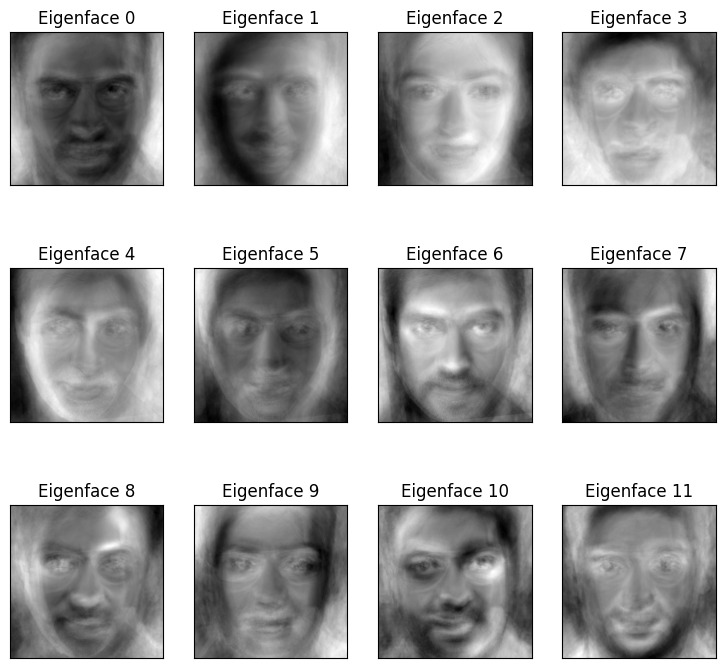

Projeceting the input data on the eigenfaces principle components
(425, 150) (25, 150)
Project done...


In [30]:
# Apply PCA for dimensionality reduction...
pca = PCA(n_components=n_components,svd_solver = "randomized",whiten=True).fit(x_train)

# Get the eigenfaces
eigenfaces = pca.components_.reshape((n_components, h, w))

# Generate titles for eigenfaces...
eigenfaces_titles = ["Eigenface %d" % i for i in range(n_components)]
plot_gallery(eigenfaces, eigenfaces_titles, h, w)
plt.show()

# Project the training and testing data onto the eigenfaces...
print("Projeceting the input data on the eigenfaces principle components")
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print(x_train_pca.shape,x_test_pca.shape)

# Apply LDA for further classification...
lda = LDA()
lda.fit(x_train_pca,y_train)
x_train_lda = lda.transform(x_train_pca)
x_test_lda = lda.transform(x_test_pca)
print("Project done...")

In [31]:
# Train a multi-layer perceptron classifier...
clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose = True).fit(x_train_lda, y_train)
print("Model weight:")
model_info = [coef.shape for coef in clf.coefs_]
print(model_info)

Iteration 1, loss = 2.32776462
Iteration 2, loss = 1.96135031
Iteration 3, loss = 1.64238682
Iteration 4, loss = 1.36076349
Iteration 5, loss = 1.11778995
Iteration 6, loss = 0.91070013
Iteration 7, loss = 0.74075533
Iteration 8, loss = 0.60091317
Iteration 9, loss = 0.48997570
Iteration 10, loss = 0.40340910
Iteration 11, loss = 0.33616117
Iteration 12, loss = 0.28519605
Iteration 13, loss = 0.24528722
Iteration 14, loss = 0.21472779
Iteration 15, loss = 0.19038445
Iteration 16, loss = 0.17067247
Iteration 17, loss = 0.15480092
Iteration 18, loss = 0.14183576
Iteration 19, loss = 0.13129883
Iteration 20, loss = 0.12281721
Iteration 21, loss = 0.11541541
Iteration 22, loss = 0.10878594
Iteration 23, loss = 0.10256844
Iteration 24, loss = 0.09738995
Iteration 25, loss = 0.09242302
Iteration 26, loss = 0.08841859
Iteration 27, loss = 0.08461067
Iteration 28, loss = 0.08131152
Iteration 29, loss = 0.07774113
Iteration 30, loss = 0.07516521
Iteration 31, loss = 0.07293103
Iteration 32, los

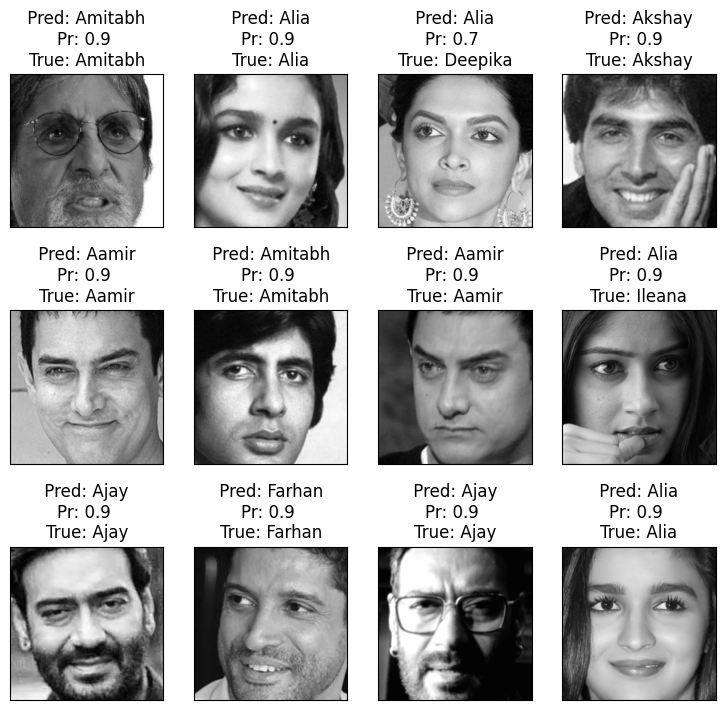

Accuracy:  84.0


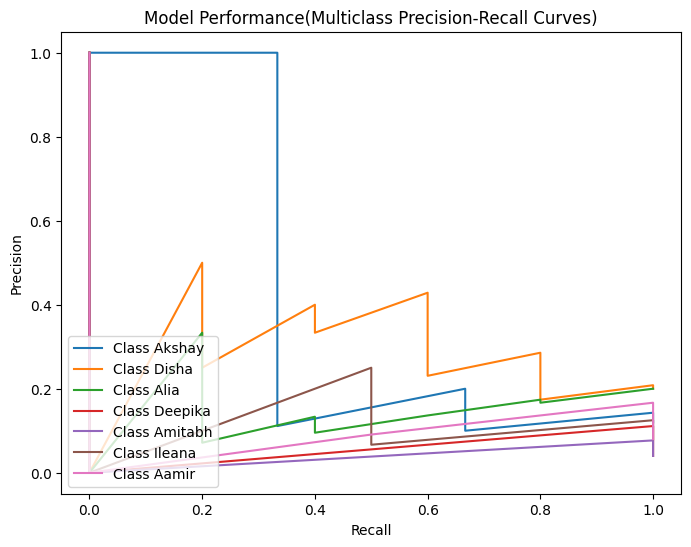

In [45]:
# Predict classes for the test data..
y_pred = []
y_proba = []
for test_face in x_test_lda:
  prob = clf.predict_proba([test_face])[0]
  class_id = np.where(prob == np.max(prob))[0][0]
  y_pred.append(class_id)
  y_proba.append(np.max(prob))
y_pred = np.array(y_pred)

# Calculate accuracy and generate titles for the predicted results...
pred_titles = []
true_positive = 0
for i in range(y_pred.shape[0]):
  true_name = class_names[y_test[i]]
  pred_name = class_names[y_pred[i]]
  result = " Pred: %s \nPr: %s \nTrue: %s" % ( pred_name, str(y_proba[i])[0:3], true_name)
  pred_titles.append(result)
  if true_name == pred_name:
    true_positive = true_positive+1

# Plot the predicted results...
plot_gallery(x_test, pred_titles, h, w)
plt.show()


# Print the accuracy...
print("Accuracy: ",true_positive*100/y_pred.shape[0])

# Plot multiclass precision-recall curves...
from sklearn.metrics import precision_recall_curve
plt.figure(figsize=(8, 6))
precision = dict()
recall = dict()

for i in range(n_classes):
    # Check if there are positive samples...
    if np.sum(y_test_bin[:, i]) > 0:
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba)
        plt.plot(recall[i], precision[i], label=f'Class {class_names[i]}')
    else:
        break

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Model Performance(Multiclass Precision-Recall Curves)')
plt.legend(loc='lower left')
plt.show()